In [1]:
import logging 
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("info")

INFO:root:info


# FlowPic Dataset

### Imports

In [2]:
from pathlib import Path

import random

from torchvision.transforms import transforms
import logging
import statistics
from abc import ABC, abstractmethod
from typing import List, Optional

import numpy as np
import pandas as pd
import torch
from PIL import Image
from matplotlib import pyplot as plt
from torch import Tensor
from torch.utils.data import Dataset


### Utils

In [3]:
def get_times_and_sized(df, direction, trim_time):
    if direction == "up":
        condition = (df["pkt_direction"] == 1) & (df["pkt_relative_time"] < trim_time) & (
                df["pkt_relative_time"] > 0)
    elif direction == "down":
        condition = (df["pkt_direction"] == 0) & (df["pkt_relative_time"] < trim_time) & (
                df["pkt_relative_time"] > 0)
    elif direction == "both":
        condition = ((df["pkt_relative_time"] < trim_time) & (df["pkt_relative_time"] > 0))
    else:
        raise ValueError(f"Invalid direction ({direction})")

    pkt_times = df[condition].pkt_relative_time
    pkt_sizes = df[condition].pkt_size
    return pkt_times, pkt_sizes

def is_flow_df_valid(df, direction, trim_time):
    """
    Valid Flow should have at least one packet. If not, it is not valid.
    :param df: flow df
    :param direction: flow direction
    :param trim_time: max sample time of flow
    :return: True for valid flow and False for invalid flow
    """
    pkt_times, pkt_sizes = get_times_and_sized(df, direction, trim_time)
    if len(pkt_sizes) == 0 or len(pkt_times) == 0:
        return False
    return True

def df_take_n_samples_per_class(df: pd.DataFrame, class_col_name: str, n=None, random_state=0):
    max_n = min(df[class_col_name].value_counts())

    if n is None or n > max_n:
        n = max_n
        print(f"df_take_n_samples_per_class setting n={n}")

    first_n_per_class_rows = df.groupby(class_col_name).sample(n=n,
                                                               random_state=random_state, replace=False)
    rest_rows = df[~df.index.isin(first_n_per_class_rows.index)]
    return first_n_per_class_rows, rest_rows

### Augmentatinos

In [4]:
class ContrastiveTransformations:

    def __init__(self, hp, n_views=2):
        """
        :param hp: hyper parameters for the augmentations
        :param n_views: The contrastive learning framework can easily be extended to have more positive examples
            by sampling more than two augmentations of the same image.
            However, the most efficient training is usually obtained by using only two.
        """
        self.hp = hp
        self.n_views = n_views
        self.retry_idx = 0  # we want to make sure that the augmented flow is valid. we would retry if it is not valid.

    def torch_vision_transform(self, img):
        hp = self.hp
        img = self.cv_color_jitter(img, hp['color_jitter_apply_prob'],
                                   hp['color_jitter_brightness'],
                                   hp['color_jitter_contrast'],
                                   hp['color_jitter_saturation'],
                                   hp['color_jitter_hue'])

        img = self.cv_flip_time_axis(img, hp['flip_time_axis_apply_prob'])

        img = self.cv_rotate_img(img, hp['rotate_img_apply_prob'],
                                 hp['rotate_img_min_angle'],
                                 hp['rotate_img_max_angle'])

        t_tensor = transforms.ToTensor()
        return t_tensor(img)

    def data_frame_transform(self, df: pd.DataFrame):
        """
        :param df: the original data frame
        :return: modified data frame with the augmentation applied
        """
        while True:
            try:
                return self._data_frame_transform(df)
            except (ValueError, IndexError) as e:
                if self.retry_idx > 1000:
                    raise FlowPicAugRetryException(
                        f'Already retired {self.retry_idx} for {self.hp.get("aug_net", "aug_net")}\n{e}\n{df}')
                self.retry_idx += 1

    def _data_frame_transform(self, origin_df: pd.DataFrame):
        df = origin_df.copy()
        if self.hp['pkt_time_min_mult_factor'] != 1 or self.hp['pkt_time_max_mult_factor'] != 1:
            mult_factor = random.uniform(self.hp['pkt_time_min_mult_factor'],
                                         self.hp['pkt_time_max_mult_factor'])
            df = self.multiple_time_axis_by_constant(df, mult_factor)

        if self.hp['pkt_time_min_move_const'] != 0 or self.hp['pkt_time_max_move_const'] != 0:
            forward_time = random.uniform(self.hp['pkt_time_min_move_const'],
                                          self.hp['pkt_time_max_move_const'])
            df = self.move_time_axis_by_constant(df, forward_time)

        if self.hp['cutout_time_window_size'] != 0:
            df = self.cut_out_time_axis_where_there_are_pkts(df, self.hp['flow_max_duration'],
                                                             self.hp['cutout_time_window_size'])

        # ret_df = self.fix_time_axis_to_start_by_first_pkt_and_trim(df, self.hp['flow_max_duration'])
        ret_df = df
        if not is_flow_df_valid(ret_df, self.hp['flow_direction'], self.hp['flow_max_duration']):
            logging.debug(
                f"invalid augmented_df: Retry={self.retry_idx}"
                f"(origin={origin_df.shape[0]})")
            raise ValueError
        self.retry_idx = 0
        return ret_df

    @staticmethod
    def multiple_time_axis_by_constant(time_series_df: pd.DataFrame, factor: float) -> pd.DataFrame:
        time_series_df = time_series_df.copy()
        time_series_df.loc[:, 'pkt_relative_time'] *= factor
        return time_series_df

    @staticmethod
    def move_time_axis_by_constant(time_series_df: pd.DataFrame, added_time: float) -> pd.DataFrame:
        time_series_df = time_series_df.copy()
        time_series_df.loc[:, 'pkt_relative_time'] += added_time
        return time_series_df

    @staticmethod
    def fix_time_axis_to_start_by_first_pkt_and_trim(time_series_df: pd.DataFrame, trim_time: int) -> pd.DataFrame:
        time_series_df = time_series_df.copy()
        time_series_df = time_series_df[time_series_df['pkt_relative_time'] >= 0]
        min_time_pkt = time_series_df['pkt_relative_time'].min()
        time_series_df.loc[:, 'pkt_relative_time'] -= min_time_pkt
        time_series_df = time_series_df[time_series_df['pkt_relative_time'] <= trim_time]

        return time_series_df

    @staticmethod
    def cut_out_time_axis_where_there_are_pkts(time_series_df: pd.DataFrame, max_time, cut_size) -> pd.DataFrame:
        time_series_df = time_series_df.copy()
        possible_times = [t for t in time_series_df['pkt_relative_time'] if (t > 0) and (t < max_time)]
        t = random.choice(possible_times)
        time_series_df = time_series_df[(time_series_df['pkt_relative_time'] < t) |
                                        (time_series_df['pkt_relative_time'] >= t + cut_size)]
        return time_series_df

    @staticmethod
    def cv_rotate_img(img, p, angle_min: int, angle_max: int):
        if random.random() < p:
            angle = random.randint(angle_min, angle_max)
            img = img.rotate(angle)
        return img

    @staticmethod
    def cv_flip_time_axis(img, p):
        return transforms.RandomHorizontalFlip(p)(img)

    @staticmethod
    def cv_color_jitter(img, p, brightness, contrast, saturation, hue):
        t = transforms.ColorJitter(brightness, contrast, saturation, hue)
        if random.random() < p:
            img = t(img)
        return img


class FlowPicAugRetryException(Exception):
    pass



### Dataset

In [5]:
class absFlowPicDataset(ABC, Dataset):
    MINIMUM_PKTS_FLOWPIC = 10
    UP = "up"
    DOWN = "down"
    BOTH = "both"

    @property
    @classmethod
    @abstractmethod
    def labels_to_indices_dict(cls) -> dict:
        # {label: idx for idx, label in enumerate(self.labels_set)}
        pass

    @property
    @classmethod
    @abstractmethod
    def indices_to_labels_dict(cls) -> dict:
        #  {idx: label for idx, label in enumerate(self.labels_set)}
        pass

    @property
    @classmethod
    @abstractmethod
    def labels_ordered_list(cls) -> list:
        pass

    def __init__(self,
                 time_series_csv_paths,
                 labels,
                 direction: str,
                 flow_max_duration: int,
                 image_size: int = 32,
                 convert_to_image_with_max_value_255=True,
                 transform: Optional[ContrastiveTransformations] = None,
                 lazy_loading: bool = False
                 ):
        super().__init__()
        self.time_series_csv_paths_list = time_series_csv_paths
        self.labels = labels
        self.direction = direction
        self.image_size = image_size
        self.convert_to_image_with_max_value_255 = convert_to_image_with_max_value_255
        self.contrastive_transform: Optional[ContrastiveTransformations] = transform
        self.trim_time: int = flow_max_duration
        self.lazy_loading = lazy_loading

        assert len(self.labels) == len(self.time_series_csv_paths_list)
        self.targets_list: List[torch.Tensor] = [Tensor([self.labels_to_indices_dict[label]]).type(torch.LongTensor) for
                                                 label in self.labels]

        self.time_series_df_list: List[pd.DataFrame] = []
        if not self.lazy_loading:
            # This would load into RAM the all dataframes, which is faster but might cause OOM errors
            for time_series_csv_path in self.time_series_csv_paths_list:
                time_series_df = pd.read_csv(time_series_csv_path)
                self.time_series_df_list.append(time_series_df)

        logging.info(f"Total {len(self.time_series_csv_paths_list)} images")
        logging.info(f"pre-loaded into RAM {len(self.time_series_df_list)} dataframe of sessions"
                     f"(with up to {self.trim_time}sec)")
        logging.info(f"labels distribution:\n{pd.DataFrame(labels).value_counts()}")

    def __len__(self):
        return len(self.time_series_csv_paths_list)

    def __getitem__(self, index):
        time_series_df = self._load_time_series_df(index)
        images = self.create_images(time_series_df, self.direction, self.trim_time, self.image_size)
        target = self.targets_list[index]
        return images, target

    def get_statistical_features(self, index):
        # • Packet size statistics: mean, minimum, maximum, and standard deviation of packet sizes.
        # • Inter-arrival time statistics: mean, minimum, maximum, and standard deviation of time differences.
        # • Flow Bytes per second (BPS).
        # • Flow packets per second (PPS).
        time_series_df = self._load_time_series_df(index)
        pkt_times, pkt_sizes = get_times_and_sized(time_series_df, self.direction, self.trim_time)
        pkt_time_diffs = [t1 - t0 for t1, t0 in zip(pkt_times[1:], pkt_times[:-1])]

        mean_pkt_size = statistics.mean(pkt_sizes)
        max_pkt_size = max(pkt_sizes)
        min_pkt_size = min(pkt_sizes)
        std_pkt_size = statistics.stdev(pkt_sizes)

        mean_pkt_time_diffs = statistics.mean(pkt_time_diffs)
        max_pkt_time_diffs = max(pkt_time_diffs)
        min_pkt_time_diffs = min(pkt_time_diffs)
        std_pkt_time_diffs = statistics.stdev(pkt_time_diffs)

        bytes_per_second = sum(pkt_sizes) / self.trim_time
        pkts_per_second = len(pkt_sizes) / self.trim_time

        return np.array([mean_pkt_size, max_pkt_size, min_pkt_size, std_pkt_size,
                         mean_pkt_time_diffs, max_pkt_time_diffs, min_pkt_time_diffs, std_pkt_time_diffs,
                         bytes_per_second, pkts_per_second])

    def get_2d_image(self, index):
        """
        get first image of the pair in index
        """
        image = self.__getitem__(index)[0][0]
        image = image.squeeze().numpy()
        # if type(image) != Image.Image:
        #     image = Image.fromarray(np.array(image).squeeze().squeeze().astype(np.uint8), mode='L')
        return image

    def get_label(self, index):
        target = int(self.__getitem__(index)[1])
        return self.indices_to_labels_dict[target]

    def create_images(self,
                      df: pd.DataFrame,
                      direction: str,
                      trim_time: int,
                      image_size: int,
                      plot: bool = False):

        imgs_list = []
        imgs_list_size = 1
        if self.contrastive_transform:
            imgs_list_size = self.contrastive_transform.n_views
        for _ in range(imgs_list_size):
            if self.contrastive_transform:
                df_i = self.contrastive_transform.data_frame_transform(df)
            else:
                df_i = df

            pkt_times, pkt_sizes = get_times_and_sized(df_i, direction, trim_time)
            try:
                histogram = self.session_2d_histogram(pkt_times, pkt_sizes, trim_time, image_size, plot=plot)
            except IndexError as e:
                logging.error(f"{df.shape=}")
                logging.error(f"{df_i.shape=}")
                logging.error(f"{pkt_times.shape=}")
                logging.error(f"{pkt_sizes.shape=}")
                logging.error(f"{df.shape=}")
                logging.error(f"df\n{df.head(20)}")
                logging.error(f"df_i\n{df_i.head(20)}")
                logging.error(f"pkt_times={pkt_times}")
                logging.error(f"pkt_sizes={pkt_sizes}")
                raise e

            if self.convert_to_image_with_max_value_255:
                # doing this so that it is consistent with image conventions and return a PIL Image
                histogram[histogram > 255] = 255

            img_i = Image.fromarray(histogram.astype(np.uint8), mode='L')
            if self.contrastive_transform:
                # Todo, notice *255 improve results drastic.. figure out why and make it better than
                img_i = self.contrastive_transform.torch_vision_transform(img_i) * 255
            else:
                img_i = torch.from_numpy(np.array(img_i)).type('torch.DoubleTensor').unsqueeze(0).float()

            imgs_list.append(img_i)
        return imgs_list

    def session_2d_histogram(self, pkt_times: List[float], pkt_sizes: List[int], trim_time: int, image_size: int,
                             max_pkt_size=1500, plot: bool = False):

        pkt_times = np.asarray(pkt_times)
        pkt_sizes = np.asarray(pkt_sizes)

        pkt_sizes[pkt_sizes > max_pkt_size] = max_pkt_size  # Replace

        pkt_times_norm = ((pkt_times - pkt_times[0]) / trim_time) * image_size
        sizes_norm = (pkt_sizes / max_pkt_size) * image_size
        H, xedges, yedges = np.histogram2d(sizes_norm, pkt_times_norm,
                                           bins=(range(0, image_size + 1, 1), range(0, image_size + 1, 1)))

        if plot:
            plt.pcolormesh(xedges, yedges, H)
            plt.colorbar()
            plt.xlim(0, image_size)
            plt.ylim(0, image_size)
            plt.set_cmap('binary')
            plt.show()

        return H.astype(np.uint8)


    def _load_time_series_df(self, index):
        if not self.lazy_loading:
            time_series_df = self.time_series_df_list[index]
        else:
            time_series_df = pd.read_csv(self.time_series_csv_paths_list[index])
        return time_series_df

    def convert_to_numpy_arrays(self, use_augmentations_data=False):
        if use_augmentations_data:
            imgs_list_size = self.contrastive_transform.n_views
            logging.info(f"convert_to_numpy_arrays: use {imgs_list_size} augmentations per sample ")
        images_list = []
        targets_list = []
        for images, target in self:
            if use_augmentations_data:
                for i in range(imgs_list_size):
                    images_list.append(images[i].numpy())
                    targets_list.append(target.numpy())
            else:
                images_list.append(images[0].numpy())
                targets_list.append(target.numpy())
        np_X = np.concatenate(images_list).reshape(len(images_list), -1)
        np_y = np.concatenate(targets_list)
        return np_X, np_y

    def convert_to_statistical_features(self):
        stats_list = []
        targets_list = []
        for idx, (_, target) in enumerate(self):
            stats_list.append(self.get_statistical_features(idx))
            targets_list.append(target.numpy())
        np_X = np.concatenate(stats_list).reshape(len(stats_list), -1)
        np_y = np.concatenate(targets_list)
        return np_X, np_y

    def convert_to_rep_vec(self, conv_net):
        if next(conv_net.parameters()).is_cuda:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = ""

        images_list = []
        targets_list = []
        conv_net.eval()
        with torch.no_grad():
            for images, target in self:
                if str(device) == 'cuda:0':
                    image = images[0].to(device)
                else:
                    image = images[0]

                h, z = conv_net(image.detach().unsqueeze(dim=0))
                images_list.append(h.cpu())
                targets_list.append(target.detach().numpy())
        conv_net.train()

        np_X = np.concatenate(images_list).reshape(len(images_list), -1)
        np_y = np.concatenate(targets_list)
        return np_X, np_y

In [6]:
class UCDavisQuicDataset(absFlowPicDataset):
    UP = "up"
    DOWN = "down"
    BOTH = "both"

    # {label: idx for idx, label in enumerate(self.labels_set)}
    labels_to_indices_dict = {
        'search': 0,
        'drive': 1,
        'youtube': 2,
        'music': 3,
        'doc': 4
    }

    #  {idx: label for idx, label in enumerate(self.labels_set)}
    indices_to_labels_dict = {
        0: 'search',
        1: 'drive',
        2: 'youtube',
        3: 'music',
        4: 'doc'
    }

    labels_ordered_list = ["search", "drive", "youtube", "music", "doc"]

    def __init__(self, dataset_path,
                 direction: str,
                 flow_max_duration: int,
                 image_size: int = 32,
                 convert_to_image_with_max_value_255=True,
                 split: str = 'train',
                 transform: Optional[ContrastiveTransformations] = None,
                 lazy_loading: bool = False,
                 small_train_size: Optional[int] = None,
                 seed=0
                 ):

        assert split in ['train', 'val', 'test', 'few-shot-train', 'all', 'small-train',
                         'small-train-random', 'test-random', 'test-human']
        if split == 'small-train' or split == 'small-train-random':
            assert small_train_size > 0
        dataset_path = Path(dataset_path)
        self.seed = seed

        index_df = pd.read_csv(dataset_path / 'index.csv')

        # Validate that with the chosen flow definition (direction+duration) we have enough packets sampled
        if flow_max_duration in [3, 15, 30, 60]:
            if flow_max_duration >= 15:
                count_interval = 15
            else:
                count_interval = 3
                
            if direction in ['up', 'down']:
                filter_cond = index_df[f'count_{direction}_pkt_in_first_{count_interval}_sec'] > \
                              self.MINIMUM_PKTS_FLOWPIC
            else:
                filter_cond = index_df[f'count_up_pkt_in_first_{count_interval}_sec'] + \
                              index_df[f'count_down_pkt_in_first_{count_interval}_sec'] > \
                              self.MINIMUM_PKTS_FLOWPIC
            index_df = index_df[filter_cond]

        index_train_df, index_val_df, index_few_shot_df, index_test_df = self.dynamic_split_data_set(index_df)
        
        labels = []
        time_series_csv_paths = []
        dataset_path = Path(dataset_path)

        if split == 'all':
            chosen_index_df = index_df
        elif split == 'train':
            chosen_index_df = index_train_df
        elif split == 'val':
            chosen_index_df = index_val_df
        elif split == 'test':
            chosen_index_df = index_test_df
        elif split == 'few-shot-train':
            chosen_index_df = index_few_shot_df
        elif split == 'small-train':
            chosen_index_df = self.create_sub_index(index_train_df, 0, small_train_size)
        elif split == 'small-train-random':
            chosen_index_df, _ = df_take_n_samples_per_class(index_train_df, 'category', n=small_train_size,
                                                             random_state=seed)
        elif split == 'test-random':
            _, not_train_df = df_take_n_samples_per_class(index_train_df, 'category', n=30,
                                                          random_state=seed)
            chosen_index_df, _ = df_take_n_samples_per_class(not_train_df, 'category', n=30,
                                                             random_state=seed)
        elif split == 'test-human':
            chosen_index_df, _ = df_take_n_samples_per_class(index_df[index_df['data_source'] == 'small_human'],
                                                             'category', n=15,
                                                             random_state=0)

        else:
            raise ValueError

        for index, row in chosen_index_df.iterrows():
            labels.append(row['category'])
            time_series_csv_paths.append(dataset_path / row['rel_path'])

        super().__init__(time_series_csv_paths=time_series_csv_paths,
                         labels=labels,
                         direction=direction,
                         flow_max_duration=flow_max_duration,
                         image_size=image_size,
                         convert_to_image_with_max_value_255=convert_to_image_with_max_value_255,
                         transform=transform,
                         lazy_loading=lazy_loading
                         )

    def create_sub_index(self, index_df, start, end, shuffle=False, seed=0):
        sub_index_df_list = []
        for label in self.labels_ordered_list:
            all_sample_with_label_df = index_df[index_df['category'] == label]
            if shuffle:
                all_sample_with_label_df = all_sample_with_label_df.sample(frac=1, random_state=seed).reset_index(
                    drop=True)

            sub_index_df_list.append(all_sample_with_label_df.iloc[start:end])
        return pd.concat(sub_index_df_list)

    def dynamic_split_data_set(self, index_df):
        # split base on ucdavis github:
        # https://github.com/shrezaei/MultitaskTrafficClassification/blob/master/dataProcessQuic.py
        np.random.seed(10)
        rand_index = np.array(range(len(index_df)))
        np.random.shuffle(rand_index)
        index_df = index_df.copy().iloc[rand_index]
        test_size = 30
        val_size = 30
        tfs_size = 30
        train_df_list = []
        test_df_list = []
        val_df_list = []
        tfs_df_list = []

        for label in self.labels_ordered_list:
            all_sample_with_label_df = index_df[index_df['category'] == label]
            test_df_list.append(all_sample_with_label_df.iloc[-test_size:])
            val_df_list.append(all_sample_with_label_df.iloc[-(test_size + val_size):-test_size])
            tfs_df_list.append(
                all_sample_with_label_df.iloc[-(test_size + val_size + tfs_size):-(test_size + val_size)])
            train_df_list.append(all_sample_with_label_df.iloc[:-(test_size + val_size + tfs_size)])

        index_train_df = pd.concat(train_df_list)
        index_test_df = pd.concat(test_df_list)
        index_val_df = pd.concat(val_df_list)
        index_few_shot_df = pd.concat(tfs_df_list)
        return index_train_df, index_val_df, index_few_shot_df, index_test_df


#### Load

In [7]:
hp ={"flow_direction": "both",
  "flow_max_duration": 15,
  "img_size": 32,
  "pkt_time_min_mult_factor": 1.2,
  "pkt_time_max_mult_factor": 0.8,
  "pkt_time_min_move_const": -0.1,
  "pkt_time_max_move_const": 0.1,
  "cutout_time_window_size": 0.1,
  "color_jitter_apply_prob": 1,
  "color_jitter_brightness": 0.0,
  "color_jitter_contrast": 0.0,
  "color_jitter_saturation": 0.0,
  "color_jitter_hue": 0.0,
  "flip_time_axis_apply_prob": 0,
  "rotate_img_apply_prob": 1,
  "rotate_img_min_angle": 0,
  "rotate_img_max_angle": 0
}


my_transform = ContrastiveTransformations(hp, n_views=1)


ds = UCDavisQuicDataset(
    dataset_path='../data/ucdavis_quic',
    direction=hp['flow_direction'],
    flow_max_duration=hp['flow_max_duration'],
    image_size=hp['img_size'],
    convert_to_image_with_max_value_255=True,
    split='test',
    transform=my_transform,
    lazy_loading=False,
    small_train_size=15)

INFO:root:Total 150 images
INFO:root:pre-loaded into RAM 150 dataframe of sessions(with up to 15sec)
INFO:root:labels distribution:
doc        30
drive      30
music      30
search     30
youtube    30
dtype: int64


#### View

In [8]:
def plot_flowpic(ax, img_index):
    ax.imshow(ds.get_2d_image(img_index), cmap=plt.get_cmap('gray_r'), origin='lower')
    plt.title(ds.get_label(img_index))

def plot_flowpic_with_axis(ax, img_index):
    random_index = random.randint(1, 100)
    ax.imshow(ds.get_2d_image(img_index), cmap=plt.get_cmap('gray_r'), origin='lower')
    plt.title(ds.get_label(img_index))

    duration = hp["flow_max_duration"]
    image_size = hp["img_size"]
    MTU=1500

    x_ticks = [0, image_size//3, 2*image_size//3, image_size]
    x_vals = [0, duration//3, 2*duration//3, duration]

    y_ticks = [0, image_size//3, 2*image_size//3, image_size]
    y_vals = [0, MTU//3, 2*MTU//3, MTU]

    plt.xticks(x_ticks, x_vals)
    plt.yticks(y_ticks, y_vals)


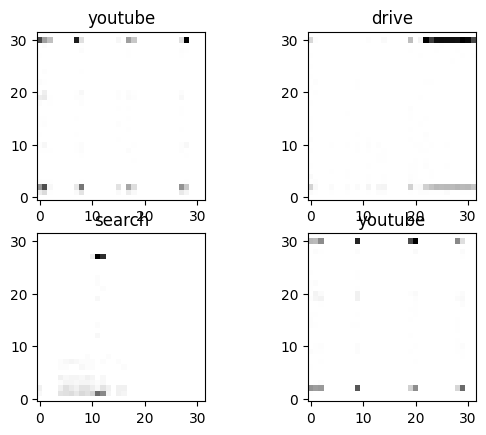

In [9]:
fig = plt.figure()
n_rows, n_cols = 2,2
for i in range(1, n_rows*n_cols+1):
    random_index = random.randint(1, 100)
    ax = fig.add_subplot(n_rows,n_cols,i)
    plot_flowpic(ax, random_index)
plt.show()

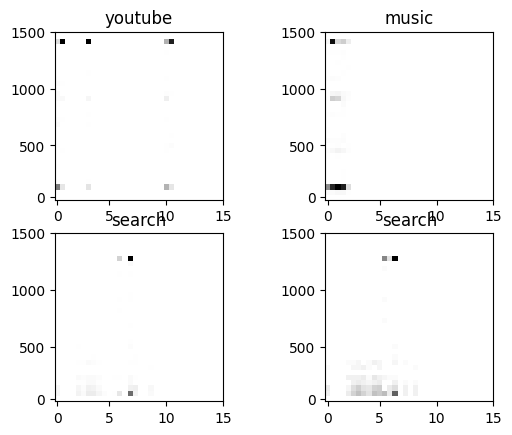

In [10]:
fig = plt.figure()
n_rows, n_cols = 2,2
for i in range(1, n_rows*n_cols+1):
    random_index = random.randint(1, 100)
    ax = fig.add_subplot(n_rows,n_cols,i)
    plot_flowpic_with_axis(ax, random_index)
plt.show()

# Training SimCLR

### Imports

In [11]:
import logging.config
import random
import os
from abc import ABC, abstractmethod
from pathlib import Path
from typing import Union, Iterable, Optional


import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.utilities.types import EPOCH_OUTPUT


### Utils

In [12]:
def get_dataloader(hp, DS_CLS, contrast_transforms, split, shuffle, lazy_loading=False):
    ds = DS_CLS(
        dataset_path=hp['ds_path'],
        direction=hp['flow_direction'],
        flow_max_duration=hp['flow_max_duration'],
        image_size=hp['img_size'],
        convert_to_image_with_max_value_255=True,
        split=split,
        transform=contrast_transforms,
        lazy_loading=lazy_loading,
        small_train_size=hp['small_train_size'],
        seed=hp['seed'])

    data_loader = data.DataLoader(
        ds,
        batch_size=hp['batch_size'],
        shuffle=shuffle,
        drop_last=False,
        pin_memory=False,
        num_workers=hp['num_workers'],
    )
    return data_loader


def get_all_data_loaders(hp):
    ds_path = Path(hp['ds_path'])
    ds_directory_name = ds_path.name
    contrast_transforms = ContrastiveTransformations(hp, n_views=2)

    if ds_directory_name == 'ucdavis_quic':
        TRAIN = 'train'
        if hp['small_train_size']:
            TRAIN = 'small-train'
        contrastive_train_loader = get_dataloader(hp, UCDavisQuicDataset, contrast_transforms, TRAIN, shuffle=True)
        contrastive_val_loader = get_dataloader(hp, UCDavisQuicDataset, contrast_transforms, 'val', shuffle=False)
        test_reg_val_loader = get_dataloader(hp, UCDavisQuicDataset, None, 'test', shuffle=False)
        few_shot_train_reg_loader = get_dataloader(hp, UCDavisQuicDataset, None, 'few-shot-train', shuffle=True)

    else:
        raise ValueError(f"{ds_path} is wrong, because {ds_directory_name} is invalid directory name")

    return contrastive_train_loader, contrastive_val_loader, test_reg_val_loader, few_shot_train_reg_loader


def get_base_model(img_size, num_classes, advanced_model=False):
    if img_size == 32:
        return BasicLeNetModel(out_vec_size=num_classes, head_type='mlp')
    #     elif img_size == 64:
    #     elif img_size == 1500:
    else:
        raise ValueError(f"Expect Image-Size to be in [32] but got {img_size}")


def create_hyper_params_dict(
        # Running environment
        ds_path: str = '../data/ucdavis_quic',
        save_model_path: Optional[str] = None,
        num_workers: int = -1,
        seed: int = 10,

        # train-test-split
        small_train_size: Optional[int] = None,
        partial_dataset_for_development_only: bool = False,

        # image creation
        flow_direction: str = 'up',
        flow_max_duration: int = 15,
        img_size: int = 32,

        # trainer and model parameters
        max_epochs: int = 10,
        monitor_metric: str = 'val_aug_acc_in_top5',
        monitor_mode: str = 'max',
        early_stop_patience: int = 3,
        batch_size: int = 32,
        eval_on_each_train_step: bool = False,

        lightning_auto_finder: bool = False,
        lr: float = 0.001,
        temperature: float = 0.07,
        weight_decay: float = 1e-4,

        representation_size: Optional[int] = None,
        similarity_vector_size: int = int(120 / 4),
        head_type: str = 'linear',

        # Augmentations
        pkt_time_min_mult_factor: int or float = 1,
        pkt_time_max_mult_factor: int or float = 1,
        pkt_time_min_move_const: int or float = 0,
        pkt_time_max_move_const: int or float = 0,
        cutout_time_window_size: int or float = 0,

        color_jitter_apply_prob: int or float = 0,
        color_jitter_brightness: int or float = 0,
        color_jitter_contrast: int or float = 0,
        color_jitter_saturation: int or float = 0,
        color_jitter_hue: int or float = 0,

        flip_time_axis_apply_prob: int or float = 0,

        rotate_img_apply_prob: int or float = 0,
        rotate_img_min_angle: int or float = 0,
        rotate_img_max_angle: int or float = 0,

        **kwargs):
    params = locals()
    kwargs = params.pop('kwargs')
    if num_workers == -1:
        device_cpu_or_cud = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        num_workers = int(os.cpu_count() // 2)
        params['num_workers'] = num_workers
    params.update(**kwargs)
    params['aug_net'] = f"mult:{pkt_time_min_mult_factor}_{pkt_time_max_mult_factor},\n" \
                        f"move:{pkt_time_min_move_const}_{pkt_time_max_move_const},\n" \
                        f"cutout:{cutout_time_window_size}"
    params['aug_cv'] = f"jitter:{color_jitter_apply_prob}_" \
                       f"{color_jitter_brightness}_{color_jitter_contrast}_" \
                       f"{color_jitter_saturation}_{color_jitter_hue},\n" \
                       f"flip:{flip_time_axis_apply_prob},\n" \
                       f"rotate:{rotate_img_apply_prob}_{rotate_img_min_angle}_{rotate_img_max_angle}"
    if params['representation_size'] is None:
        params['representation_size'] = get_base_model(params['img_size'],
                                                       params['similarity_vector_size']).rep_vec_size
    return params

### Base Models

In [13]:
class ABSModel(nn.Module, ABC):
    def __init__(self, rep_vec_size, out_vec_size, head_type):
        super().__init__()
        self.rep_vec_size = rep_vec_size
        self.out_vec_size = out_vec_size
        self.head_type = head_type
        if self.head_type == 'linear':
            f6 = nn.Linear(in_features=self.rep_vec_size, out_features=self.out_vec_size)
            self.projection_head = f6

        elif self.head_type == 'mlp':
            f6 = nn.Linear(in_features=self.rep_vec_size, out_features=self.rep_vec_size)
            f7 = nn.Linear(in_features=self.rep_vec_size, out_features=self.out_vec_size)
            self.projection_head = nn.Sequential(f6, nn.ReLU(), f7)
        else:
            raise ValueError(f"head should linear or mlp (but {self.head_type} given)")

    @abstractmethod
    def representation_extractor(self, x, print_sizes=False):
        pass

    def forward(self, x):
        h = self.representation_extractor(x)
        z = self.projection_head(h)
        return h, z


class BasicLeNetModel(ABSModel):
    def __init__(self,
                 img_channels=1, img_size=(32, 32),
                 conv1_out_channels=6, conv1_kernel_size=(5, 5),
                 subsample1_kernel_size=2,
                 conv2_out_channels=16, conv2_kernel_size=(5, 5),
                 subsample2_kernel_size=2,
                 conv3_out_channels=120, conv3_kernel_size=(5, 5),
                 out_vec_size=10,
                 head_type='linear'):
        conv1_in_channels = img_channels
        conv2_in_channels = conv1_out_channels
        conv3_in_channels = conv2_out_channels

        assert img_size[0] == img_size[1]  # support only square images for now
        rep_vec_size = int((img_size[0] - conv1_kernel_size[0] + 1) / subsample1_kernel_size)
        rep_vec_size = int((rep_vec_size - conv2_kernel_size[0] + 1) / subsample2_kernel_size)
        rep_vec_size = int((rep_vec_size - conv3_kernel_size[0] + 1))
        rep_vec_size = conv3_out_channels * (rep_vec_size ** 2)
        print(f"calculated rep_vec_size {rep_vec_size}")
        super().__init__(rep_vec_size, out_vec_size, head_type)

        self.c1 = nn.Conv2d(in_channels=conv1_in_channels, out_channels=conv1_out_channels,
                            kernel_size=conv1_kernel_size)
        self.s2 = nn.AvgPool2d(kernel_size=subsample1_kernel_size)
        self.c3 = nn.Conv2d(in_channels=conv2_in_channels, out_channels=conv2_out_channels,
                            kernel_size=conv2_kernel_size)
        self.s4 = nn.AvgPool2d(kernel_size=subsample2_kernel_size)
        self.c5 = nn.Conv2d(in_channels=conv3_in_channels, out_channels=conv3_out_channels,
                            kernel_size=conv3_kernel_size)

        assert rep_vec_size == \
               torch.flatten(self.representation_extractor(torch.rand((1, 1, img_size[0], img_size[1])), True)).shape[0]

    def representation_extractor(self, x, print_sizes=False):
        out = nn.Tanh()(self.c1(x))
        out = self.s2(out)
        out = nn.Tanh()(self.c3(out))
        out = self.s4(out)
        out = nn.Tanh()(self.c5(out))
        out = torch.flatten(out, 1)
        return out


### SimCLR framework

In [14]:
class SimCLR(pl.LightningModule):
    def __init__(self, representation_size, similarity_vector_size, head_type, lr, temperature, weight_decay,
                 max_epochs, eval_on_each_train_step=False, img_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.img_size = img_size
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        self.conv_net = get_base_model(self.img_size, similarity_vector_size)
        assert self.conv_net.rep_vec_size == representation_size

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, feats, mode="train"):
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        if mode in ["train", "val"]:
            self._unsupervised_augmentation_similarity_metrics(mode, cos_sim, pos_mask)

        return nll

    def training_step(self, batch, batch_idx, dataloader_idx=0):
        h, z = self._apply_conv_net(batch)
        loss = self.info_nce_loss(z, mode="train")
        return {"loss": loss, "h": h.detach(), "z": z.detach()}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        h, z = self._apply_conv_net(batch)
        self.info_nce_loss(z, mode="val")
        return {"h": h.detach(), "z": z.detach()}

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        h, z = self._apply_conv_net(batch)
        self.info_nce_loss(z, mode="test")
        return {"h": h.detach(), "z": z.detach()}

    def training_epoch_end(self, outputs: EPOCH_OUTPUT) -> None:
        pass

    def test_epoch_end(self, outputs: EPOCH_OUTPUT) -> None:
        pass

    def _get_y_true(self, batch):
        # for debugging
        images, target = batch
        y_true = target.squeeze(1)
        y_true = torch.cat([y_true] * len(images), dim=0)
        return y_true

    def _get_raw_x(self, batch):
        # for debugging
        images, _ = batch
        images = torch.cat([img.view(img.shape[0], -1) for img in images], dim=0)
        return images

    def _apply_conv_net(self, batch):
        images, _ = batch
        images = torch.cat(images, dim=0)
        # Encode all images
        h, z = self.conv_net(images)
        return h, z

    def _unsupervised_augmentation_similarity_metrics(self, mode, cos_similarity, positive_mask):
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_similarity[positive_mask][:, None],
             cos_similarity.masked_fill(positive_mask, -9e15)],
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(f"{mode}_aug_acc_in_top1", (sim_argsort == 0).float().mean())
        self.log(f"{mode}_aug_acc_in_top5", (sim_argsort < 5).float().mean())
        self.log(f"{mode}_aug_mean_distance", 1 + sim_argsort.float().mean())

### Train

In [15]:
def setup_trainer(max_epochs: int,
                  monitor_metric: Optional[str],
                  monitor_mode: Optional[str],
                  early_stop_patience: Optional[int] = 3,
                  lightning_auto_finder=False,
                  logger: Union[LightningLoggerBase, Iterable[LightningLoggerBase], bool] = True,
                  pl_root_dir: str = "/tmp/SimCLR"):
    callbacks_list = [LearningRateMonitor("step")]
    if monitor_mode and monitor_metric:
        callbacks_list.append(ModelCheckpoint(monitor=monitor_metric, mode=monitor_mode)),
        callbacks_list.append(EarlyStopping(monitor=monitor_metric, mode=monitor_mode, patience=early_stop_patience))

    pl_trainer = pl.Trainer(
        default_root_dir=pl_root_dir,
        gpus=1 if torch.cuda.is_available() else 0,
        logger=logger,
        max_epochs=max_epochs,
        callbacks=callbacks_list,
        auto_lr_find=lightning_auto_finder,
        progress_bar_refresh_rate=1,
        log_every_n_steps=1,
        # check_val_every_n_epoch=10,
        num_sanity_val_steps=0
    )

    pl_trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    return pl_trainer


def train_simclr(pl_trainer, unsupervised_train_loader: data.DataLoader, unsupervised_val_loader: data.DataLoader,
                 eval_on_each_train_step: bool, **kwargs):
    model = SimCLR(max_epochs=pl_trainer.max_epochs, eval_on_each_train_step=eval_on_each_train_step, **kwargs)
    pl_trainer.fit(model,
                   train_dataloaders=unsupervised_train_loader,
                   val_dataloaders=unsupervised_val_loader)

    return model


In [16]:
pl_root_dir = "/tmp/SimCLR"

hyper_parameters = create_hyper_params_dict(
    project_name="example-notebook",
    experiment_name="example-experiment",
    max_epochs=3,
    partial_dataset_for_development_only=True,
    batch_size=32,
    img_size=32,
    eval_on_each_train_step=True,
    pkt_time_min_mult_factor=0.5,
    pkt_time_max_mult_factor=1.5,
    pkt_time_min_move_const=-1,
    pkt_time_max_move_const=1,
    seed=50)

contra_train_dataloader, contra_val_dataloader, test_reg_val_loader, _ = get_all_data_loaders(hyper_parameters)

pl.seed_everything(hyper_parameters['seed'], workers=True)

trainer = setup_trainer(max_epochs=hyper_parameters['max_epochs'],
                        monitor_metric=hyper_parameters['monitor_metric'],
                        monitor_mode=hyper_parameters['monitor_mode'],
                        early_stop_patience=hyper_parameters['early_stop_patience'],
                        lightning_auto_finder=hyper_parameters['lightning_auto_finder'],
                        logger=True,
                        pl_root_dir=pl_root_dir)

model = train_simclr(pl_trainer=trainer, unsupervised_train_loader=contra_train_dataloader,
                     unsupervised_val_loader=contra_val_dataloader,
                     eval_on_each_train_step=hyper_parameters['eval_on_each_train_step'],
                     representation_size=hyper_parameters['representation_size'],
                     similarity_vector_size=hyper_parameters['similarity_vector_size'],
                     head_type=hyper_parameters['head_type'], lr=hyper_parameters['lr'],
                     temperature=hyper_parameters['temperature'], weight_decay=hyper_parameters['weight_decay'])

model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, **model.hparams)
trainer.test(model, test_reg_val_loader)

# Save
if hyper_parameters['save_model_path']:
    logging.info(f"save model to {hyper_parameters['save_model_path']}")
    torch.save(model.conv_net, hyper_parameters['save_model_path'])

calculated rep_vec_size 120


INFO:root:Total 6219 images
INFO:root:pre-loaded into RAM 6219 dataframe of sessions(with up to 15sec)
INFO:root:labels distribution:
search     1870
drive      1590
doc        1175
youtube    1037
music       547
dtype: int64
INFO:root:Total 150 images
INFO:root:pre-loaded into RAM 150 dataframe of sessions(with up to 15sec)
INFO:root:labels distribution:
doc        30
drive      30
music      30
search     30
youtube    30
dtype: int64
INFO:root:Total 150 images
INFO:root:pre-loaded into RAM 150 dataframe of sessions(with up to 15sec)
INFO:root:labels distribution:
doc        30
drive      30
music      30
search     30
youtube    30
dtype: int64
INFO:root:Total 150 images
INFO:root:pre-loaded into RAM 150 dataframe of sessions(with up to 15sec)
INFO:root:labels distribution:
doc        30
drive      30
music      30
search     30
youtube    30
dtype: int64
INFO:pytorch_lightning.utilities.seed:Global seed set to 50
/home/eyal/dev/eyal-thesis/mini-flowpic-traffic-classification/venv/

calculated rep_vec_size 120


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

calculated rep_vec_size 120


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 9.51502513885498}
--------------------------------------------------------------------------------


## Visualize the learned representation

### Utils

In [17]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap


In [18]:
def plot_umap_davis(X, y, title, emebd_x=None, save_dir=None):
    reducer = umap.UMAP(random_state=42)
    if emebd_x is None:
        embed = reducer.fit_transform(X)
    else:
        embed = emebd_x

    sns.set(context="paper", style="white")
    labels_int = y.astype(int).reshape(-1)
    max_class_index = max(labels_int) + 1
    palette = np.array(sns.color_palette("hls", max_class_index))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(embed[:, 0], embed[:, 1], lw=0, s=6, c=palette[labels_int])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    plt.setp(ax, xticks=[], yticks=[])
    # plt.title(title, fontsize=18)

    ax.axis('tight')

    indices_to_labels_dict = {
        0: 'g_search',
        1: 'g_drive',
        2: 'youtube',
        3: 'g_music',
        4: 'g_doc'
    }
    # Add the label caption
    txts = []
    for i in np.unique(labels_int):
        # Position of each label.
        xtext, ytext = np.median(embed[(labels_int == i).reshape(-1)], axis=0)
        txt = ax.text(xtext, ytext, str(indices_to_labels_dict[i]), fontsize=16, color=palette[i])
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title(title)
    plt.show()
    # return embed
    return 

def ucdavis_train_ds(hp, n_views=10):
    train_transform = ContrastiveTransformations(hp, n_views=n_views)
    print(train_transform)
    return UCDavisQuicDataset(
        dataset_path=hp['ds_path'],
        direction=hp['flow_direction'],
        flow_max_duration=hp['flow_max_duration'],
        image_size=hp['img_size'],
        convert_to_image_with_max_value_255=True,
        split=hp['split'],
        transform=train_transform,
        lazy_loading=False,
        small_train_size=hp['small_train_size'],
        seed=hp['seed'])



### View

In [29]:
identity_hp = {
        'ds_path': '../data/ucdavis_quic',
        'seed': 10,
        'flow_direction': 'up',
        'flow_max_duration': 15,
        'img_size': 32,
        'small_train_size': None,
        'split' : 'test-random',
        'pkt_time_min_mult_factor': 1,
        'pkt_time_max_mult_factor': 1,
        'pkt_time_min_move_const': 0,
        'pkt_time_max_move_const': 0,
        'cutout_time_window_size': 0,
        'color_jitter_apply_prob': 0,
        'color_jitter_brightness': 0,
        'color_jitter_contrast': 0,
        'color_jitter_saturation': 0,
        'color_jitter_hue': 0,
        'flip_time_axis_apply_prob': 0,
        'rotate_img_apply_prob': 0,
        'rotate_img_min_angle': 0,
        'rotate_img_max_angle': 0,
    }

conv_net = model.conv_net
ds_for_visualization = ucdavis_train_ds(identity_hp)


INFO:root:Total 150 images
INFO:root:pre-loaded into RAM 150 dataframe of sessions(with up to 15sec)
INFO:root:labels distribution:
doc        30
drive      30
music      30
search     30
youtube    30
dtype: int64


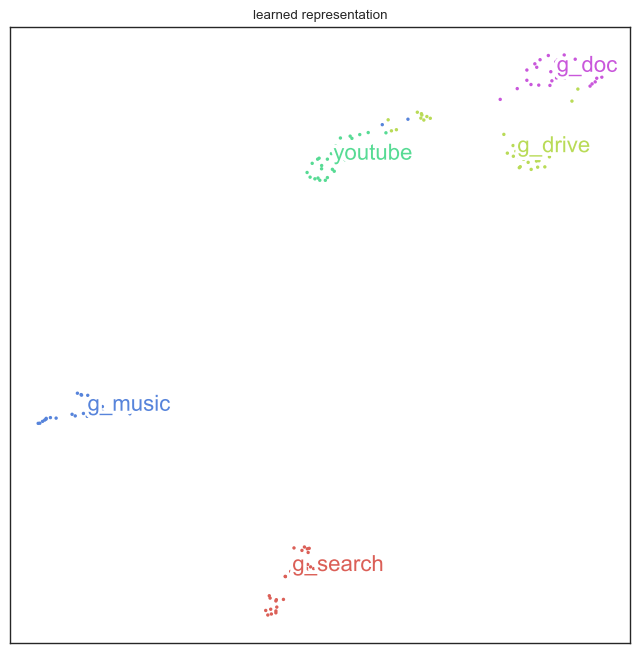

In [30]:
# UMAP rep-vec
rep_vec_tuple = ds_for_visualization.convert_to_rep_vec(conv_net)
plot_umap_davis(rep_vec_tuple[0], rep_vec_tuple[1], 'learned representation')

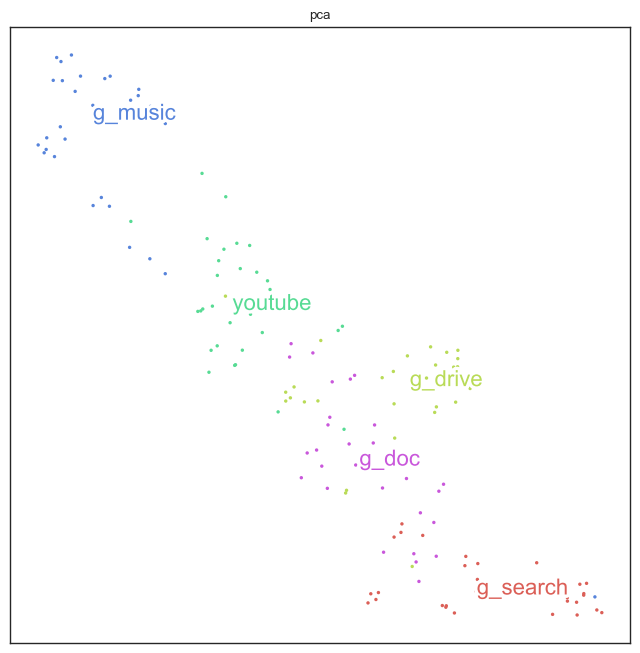

In [31]:
# UMAP PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=120)  # Choose number of components
raw_data_tuple = ds_for_visualization.convert_to_numpy_arrays()
pca.fit(raw_data_tuple[0])
pca_data = pca.transform(raw_data_tuple[0])
plot_umap_davis(pca_data, raw_data_tuple[1], 'pca')

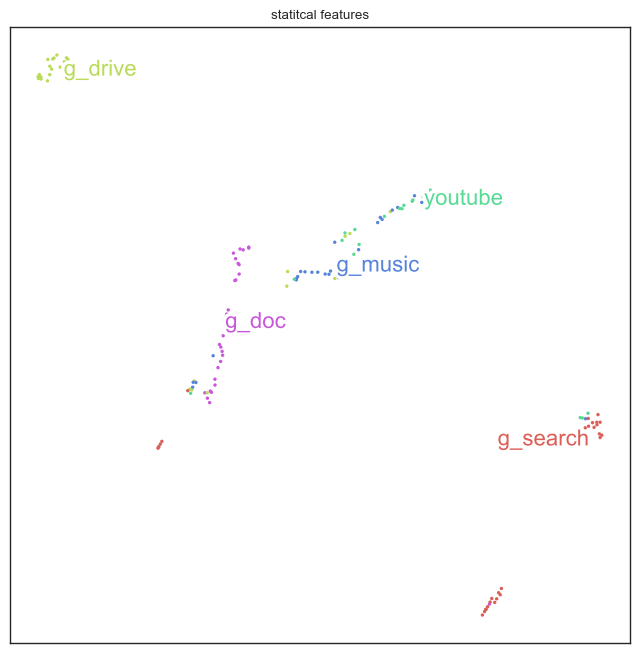

In [32]:
# statitcal features
stat_feat_tuple = ds_for_visualization.convert_to_statistical_features()
plot_umap_davis(stat_feat_tuple[0], stat_feat_tuple[1], 'statitcal features')